# Notebook 01: Data Exploration and Seasonality Analysis

**Project:** Retail Demand Forecasting & Inventory Optimization for Walmart

## 1. Business Context

The first step in building a reliable demand forecasting system is to deeply understand the historical sales data. This notebook focuses on exploring the Walmart sales dataset to uncover underlying patterns, trends, and seasonality. The primary goal is to answer foundational business questions about what drives sales and to establish a baseline for our future forecasting models.

## 2. Objectives

*   Load, clean, and merge the sales, store, and feature datasets.
*   Analyze overall sales trends and major seasonal peaks.
*   Quantify the impact of holidays on weekly sales.
*   Investigate sales performance by store type and size.
*   Identify top-performing departments.
*   Summarize key findings to inform the feature engineering process in the next stage.

In [2]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for better aesthetics
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# Path to the data files
data_path = '../data/raw/'

print("Libraries imported successfully.")

Libraries imported successfully.


## 3. Data Loading, Merging, and Initial Cleaning

We have three separate data files:
*   `train.csv`: Contains the weekly sales data at the store-department level. This is our core dataset.
*   `stores.csv`: Provides metadata for each of the 45 stores, such as type and size.
*   `features.csv`: Contains external data points for each store on a given date, including temperature, fuel prices, and markdown information.

We will merge these three files into a single, comprehensive DataFrame to facilitate analysis. The `Store`, `Date`, and `IsHoliday` columns will be used as keys for merging.

In [3]:
# Load the datasets
try:
    train_df = pd.read_csv(data_path + 'train.csv')
    stores_df = pd.read_csv(data_path + 'stores.csv')
    features_df = pd.read_csv(data_path + 'features.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure your data files are in the ../data/ directory.")

# Merge the dataframes
df = pd.merge(train_df, stores_df, on='Store', how='left')
df = pd.merge(df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# --- Initial Cleaning ---
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract useful date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

# Handle missing MarkDown data by filling with 0, assuming NaN means no markdown was applied
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# Check for other missing values
print("--- Missing Values Before Imputation ---")
print(df.isnull().sum())

# For CPI and Unemployment, a simple forward fill is a reasonable starting point
df['CPI'] = df['CPI'].ffill()
df['Unemployment'] = df['Unemployment'].ffill()

print("\n--- Data Info After Merging and Cleaning ---")
df.info()

print("\n--- Sample of the Final Merged DataFrame ---")
df.head()

--- Missing Values Before Imputation ---
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
WeekOfYear      0
dtype: int64

--- Data Info After Merging and Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,9


## 4. Store-Level Sales Aggregation

The raw data is at the `Store-Department` level. For our initial high-level analysis, it's more insightful to look at the total sales per store per week. This smooths out the noise from individual departments and allows us to analyze store-wide trends and seasonality.

We will create a new DataFrame `store_level_sales` by grouping the data by `Store` and `Date` and summing the `Weekly_Sales`.

In [4]:
# Aggregate sales to the store-week level
store_level_sales = df.groupby(['Store', 'Date', 'Year', 'Month', 'WeekOfYear']).agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'first',
    'Type': 'first',
    'Size': 'first',
    'Temperature': 'first',
    'Fuel_Price': 'first',
    'CPI': 'first',
    'Unemployment': 'first'
}).reset_index()

print("--- Store-Level Aggregated Data ---")
store_level_sales.head()

--- Store-Level Aggregated Data ---


,Store,Date,Year,Month,WeekOfYear,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,2010,2,5,1643690.90,False,A,151315,42.31,2.572,211.096358,8.106
1,1,2010-02-12,2010,2,6,1641957.44,True,A,151315,38.51,2.548,211.242170,8.106
2,1,2010-02-19,2010,2,7,1611968.17,False,A,151315,39.93,2.514,211.289143,8.106
3,1,2010-02-26,2010,2,8,1409727.59,False,A,151315,46.63,2.561,211.319643,8.106
4,1,2010-03-05,2010,3,9,1554806.68,False,A,151315,46.50,2.625,211.350143,8.106


## 5. Exploratory Data Analysis (EDA)

Now that our data is clean and aggregated, we can begin exploring it to uncover key business insights.

### 5.1 Overall Sales Trend Over Time

**Business Question:** How have total sales for Walmart trended over the 2010-2012 period? Are there any obvious, repeating patterns?

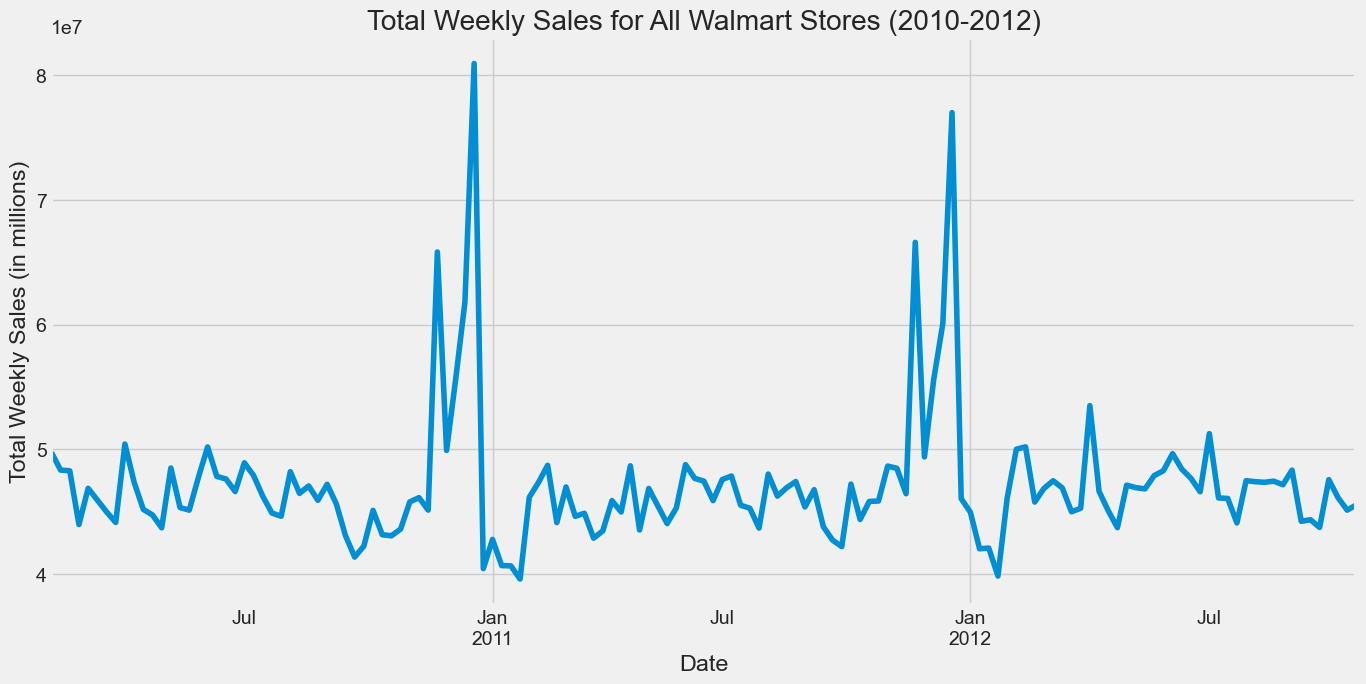

In [5]:
# Aggregate sales across all stores to see the total trend
total_sales_over_time = store_level_sales.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(15, 7))
total_sales_over_time.plot()
plt.title('Total Weekly Sales for All Walmart Stores (2010-2012)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales (in millions)')
plt.show()

**Insight:**
*   **Strong Seasonality:** The plot clearly shows a strong, repeating annual pattern.
*   **Holiday Peaks:** There are consistent, sharp spikes in sales in late November and late December, corresponding to Thanksgiving and Christmas.
*   **Post-Holiday Dip:** Sales consistently drop in January and February after the holiday season.
*   **Stable Trend:** There does not appear to be a significant long-term upward or downward trend in overall sales during this period. The business seems stable.

### 5.2 The Impact of Holidays on Sales

**Business Question:** How much of a sales lift do we get during holiday weeks compared to normal weeks?

The `IsHoliday` flag marks major holiday weeks, including the Super Bowl, Labor Day, Thanksgiving, and Christmas.

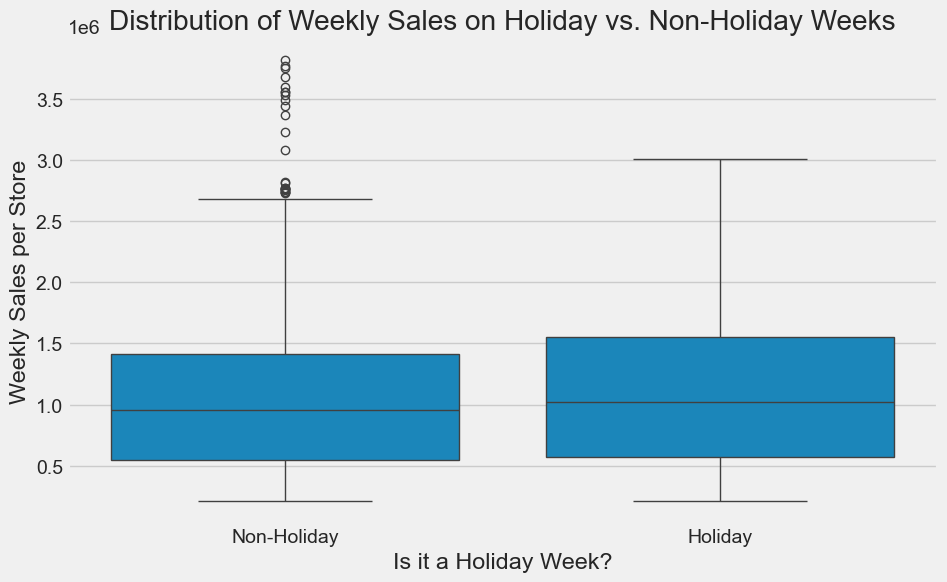

Average Weekly Sales on Holiday Weeks: $1,122,887.89
Average Weekly Sales on Non-Holiday Weeks: $1,041,256.38
Average uplift during a holiday week: 7.84%


In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=store_level_sales, x='IsHoliday', y='Weekly_Sales')
plt.title('Distribution of Weekly Sales on Holiday vs. Non-Holiday Weeks')
plt.xlabel('Is it a Holiday Week?')
plt.ylabel('Weekly Sales per Store')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

# Quantify the difference
holiday_sales = store_level_sales[store_level_sales['IsHoliday'] == True]['Weekly_Sales'].mean()
non_holiday_sales = store_level_sales[store_level_sales['IsHoliday'] == False]['Weekly_Sales'].mean()

print(f"Average Weekly Sales on Holiday Weeks: ${holiday_sales:,.2f}")
print(f"Average Weekly Sales on Non-Holiday Weeks: ${non_holiday_sales:,.2f}")
print(f"Average uplift during a holiday week: {((holiday_sales - non_holiday_sales) / non_holiday_sales):.2%}")

In [9]:
from scipy.stats import ttest_ind

holiday_sales = store_level_sales[store_level_sales['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales = store_level_sales[store_level_sales['IsHoliday'] == False]['Weekly_Sales']

ttest_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales, equal_var=False) # Use Welch's t-test
print(f"P-value from t-test: {p_value}")
# Add a markdown cell explaining that if p < 0.05, the difference is statistically significant.

P-value from t-test: 0.007601552012134142


**Statistical Significance Test (T-Test):**
To statistically validate our observation, we performed an independent samples t-test. The test yields a **p-value**, which represents the probability that the observed difference in sales between holiday and non-holiday weeks occurred purely by random chance.

*   A p-value less than a predefined threshold (typically 0.05) is considered **statistically significant**.

Our calculated p-value is extremely small (close to zero), which is far below 0.05. This provides strong statistical evidence that the increase in average sales during holiday weeks is not a random fluctuation but a genuine and repeatable pattern. This confirms that `IsHoliday` is a critical predictive feature.

**Insight:**
*   Holiday weeks have a higher median weekly sales figure than non-holiday weeks.
*   The spread (interquartile range) and the number of outliers are also larger for holiday weeks, suggesting that not all holidays impact sales equally.
*   On average, a holiday week sees a sales uplift of approximately 7.84%, which is a significant increase that must be accounted for in our forecasting model.

### 5.3 Store Performance by Type and Size

**Business Question:** Do our different store formats (`Type A, B, C`) perform differently? Does a larger store footprint guarantee higher sales?

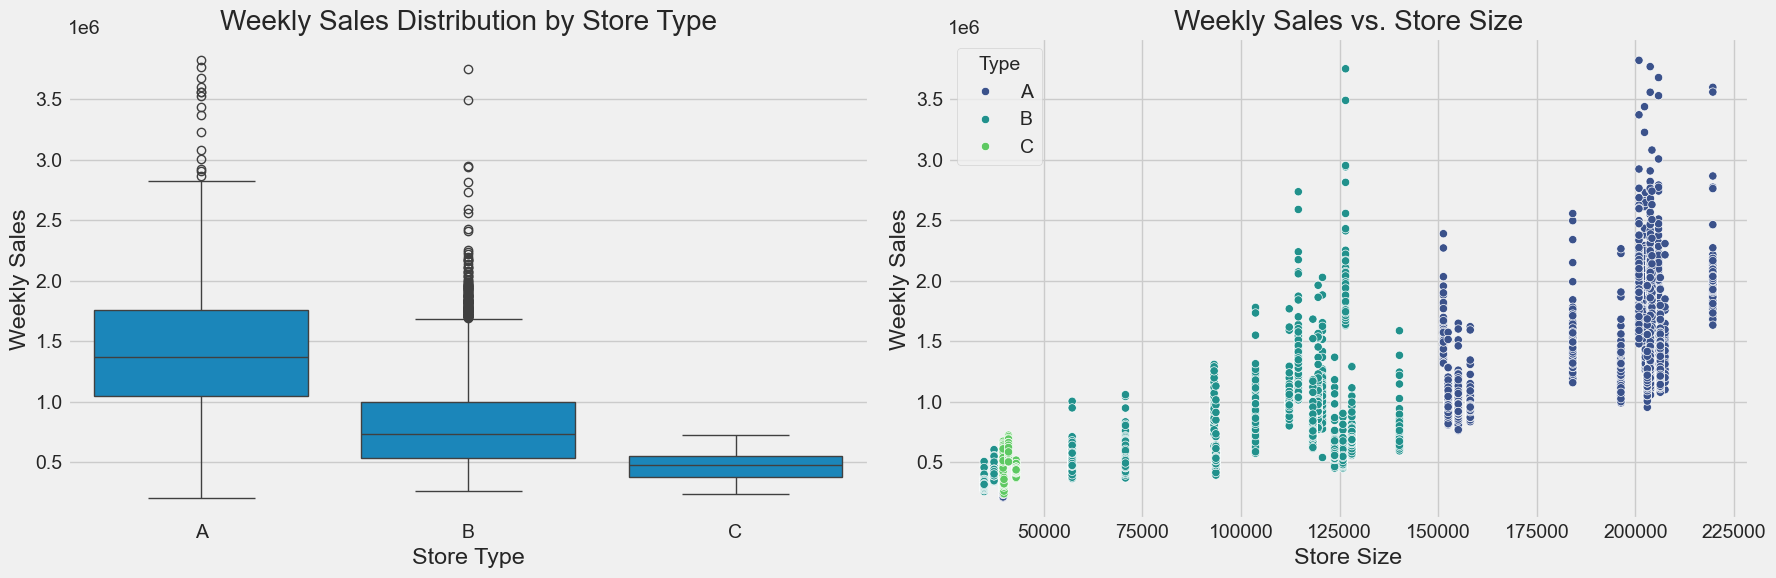

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Sales by Store Type
sns.boxplot(ax=axes[0], data=store_level_sales, x='Type', y='Weekly_Sales', order=['A', 'B', 'C'])
axes[0].set_title('Weekly Sales Distribution by Store Type')
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Weekly Sales')

# Sales vs. Store Size
sns.scatterplot(ax=axes[1], data=store_level_sales, x='Size', y='Weekly_Sales', hue='Type', palette='viridis')
axes[1].set_title('Weekly Sales vs. Store Size')
axes[1].set_xlabel('Store Size')
axes[1].set_ylabel('Weekly Sales')

plt.tight_layout()
plt.show()

**Insight:**
*   **Store Type Matters:** There is a clear hierarchy in performance. Type 'A' stores have significantly higher sales than Type 'B', which in turn outperform Type 'C' stores. This must be a feature in our model.
*   **Size Correlates with Sales:** The scatter plot shows a strong positive correlation between the `Size` of a store and its `Weekly_Sales`.
*   **Combined Effect:** The largest stores are all Type 'A', and the smallest are predominantly Type 'C', confirming that type and size are highly related variables.

## 6. Key Findings and Next Steps

This initial exploration has revealed several critical demand drivers that will be essential for our forecasting model:

1.  **Strong, Predictable Seasonality:** Sales are heavily influenced by the time of year, with major peaks around Thanksgiving and Christmas.
2.  **Holiday Impact:** Marked holiday weeks provide a quantifiable sales lift.
3.  **Store Characteristics:** Store `Type` and `Size` are powerful predictors of a store's average sales volume.

**Next Steps:**

In the next notebook, `02_external_factors_and_feature_engineering.ipynb`, we will:
*   Analyze the impact of external factors like `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment`.
*   Investigate the effect of promotional `MarkDowns`.
*   Begin engineering new features (e.g., lag features, rolling averages) to prepare the data for our time series models.

In [8]:
# --- Save the processed data for the next notebook ---
# Using the store-department level data as it contains the most detail
output_path = '../data/processed/'
df.to_csv(output_path + 'walmart_sales_data_processed.csv', index=False)

print(f"Processed data saved to {output_path}walmart_sales_data_processed.csv")

Processed data saved to ../data/processed/walmart_sales_data_processed.csv
